# Group 16: SIT307 Machine Learning Group Project (Assignment 3)

<br>
Dataset Selected: <b>COVID-19 World Vaccination Progress</b>

Found at: https://www.kaggle.com/gpreda/covid-world-vaccination-progress

Collected by: <b>Gabriel Preda</b>

Updated: <b>Daily</b>

Date of download used: <b>6th May 2021</b>

<br><br>
<b>Supplementary data sets found at:</b>

https://www.kaggle.com/tanuprabhu/population-by-country-2020

https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

#### Import libraries used

In [3]:
# import libraries used
import numpy as np
import pandas as pd
pd.set_option('precision', 2)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
import datetime as dt

### Functions Used in this Notebook

In [4]:
""" 
    Funtion that calculates mean squared error
    Requires:
        predictions made by model
        Ytest correct outcomes
"""
def MSE(predictions, Ytest):
    return np.mean((predictions - Ytest) ** 2)

In [5]:
""" 
    Funtion to convert date in string format to ordinal
    Requires:
        a date in string format (DD/MM/YYYY)
"""
def date_to_ordinal(date):
    return datetime.strptime(date, '%d/%m/%Y').date().toordinal()

In [6]:
""" 
    Funtion to convert date column in string/object format to ordinal
    Requires:
        a date column in a dataframe
"""

def date_to_ordinal_df(df):
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].map(dt.datetime.toordinal)
    return df

In [7]:
""" 
    Funtion to convert ordinal number to date format
    Requires:
        an ordinal number (int)
"""
def ordinal_to_datetime(ordinal):
    ordinal_to_datetime = int(ordinal)
    ordinal_to_datetime = dt.date.fromordinal(abs(ordinal_to_datetime))
    return ordinal_to_datetime

In [8]:
""" 
    Funtion to convert date column in ordianl format to date
    Requires:
        a date column in a dataframe in ordinal (ints)
"""
def ordinal_to_datetime_arr(arr):
    new_arr = []
    for num in arr:
        num = int(num)
        new_arr.append(dt.date.fromordinal(abs(num)))
    return new_arr

In [9]:
""" 
    Funtion that plots linear regression and real data
    Requires:
        X data set
        Y data set
        X test data set
        predictions made by model
"""
def plot_LR(X, Y, Xtest, predictions):
    # Plot outputs
    plt.scatter(X, Y,  color='red', s=5)
    plt.plot(Xtest, predictions, color='blue', linewidth=3)
    plt.xticks(rotation=90)

    # show plot
    plt.show()

## Kelly's Section

### Prediction of What Date a Country Will Have Vaccinated a Provided Percentage of Their Population

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a target percentage, this section will determine what date the country provided will achieve the target percentage of population vaccinated.
<br>

In [10]:
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [11]:
# take only the columns of interest
vaccination_1 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_1.shape)

(15344, 3)


In [12]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_1 = vaccination_1[vaccination_1['people_fully_vaccinated_per_hundred'].notna()]

# change date object to ordinal to be used in linear regression
date_to_ordinal_df(vaccination_1)

# print the new shape
print(vaccination_1.shape)

(6343, 3)


In [13]:
""" 
    Function to find a date of the given target percentage for the population fully vaccinated
    Requires:
        -the pandas dataframe being worked on
        -a valid country in string format, and
        -target percentage
"""

def date_to_be_target_percentage(df, country, percentage, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        determin_date = (LR.intercept_ - percentage )/LR.coef_
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the date of the target percentage for the fully vaccinated of country population
        # the mean squared error, the Y intercept and the slope
        return determin_date, mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for people_fully_vaccinated_per_hundred.")
        return False, False, False, False

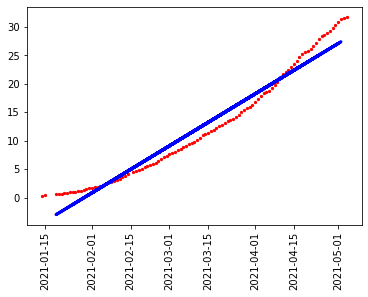

We predict that 85% of the United States population will be fully immunized by 2021-11-13.


In [14]:
# determine a country to investigate
country_for_perc = 'United States'

# determine a date
target_percentage_of_immunization = 85

# call function with the dataset, country and target_percentage_of_immunization
# store returned values to be printed
date, mse, y_intercept, slope = date_to_be_target_percentage(vaccination_1, country_for_perc, target_percentage_of_immunization, True)
print("We predict that {0}% of the {1} population will be fully immunized by {2}.".format(target_percentage_of_immunization, country_for_perc, ordinal_to_datetime(date)))

<br>

## Sean's Section

### Prediction of What Percentage of a Countries Population Will Be Vaccinated by a Given Date

Implementing univariant linear regression on people fully vaccinated per hundred by date for different countries. Providing a country and a date, this section will determine what percentage of the countries population will be fully vaccinated by the provided date. If the date provided gives a value of over 100% (the country has fully vaccinated their population before this date), a further machine learning model will be called to determine what date they are predicted to achieve 100% vaccination.
<br><br>
Some countries don't provide data in the people_fully_vaccinated_per_hundred column. When this is the case the function will return this fact. If this is the case, there is a second machine learning model further down which uses total_vaccinations_per_hundred to determine how many vaccinations have been administered scaled to the population (maximum of 200% for 2 doses for each person).

In [15]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [16]:
# take only the columns of interest
vaccination_2 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]

# show this shape
print(vaccination_2.shape)

(15344, 3)


In [17]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_2 = vaccination_2[vaccination_2['people_fully_vaccinated_per_hundred'].notna()]

# print the new shape
print(vaccination_2.shape)

(6343, 3)


In [18]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_2['date'] = pd.to_datetime(vaccination_2['date'])
vaccination_2['date'] = vaccination_2['date'].map(dt.datetime.toordinal)

In [19]:
""" 
    Funtion to determine the percentage of the given countries population fully vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_fully_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_fully_vaccinated_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_fully_vaccinated_per_hundred".format(country))
        return False, False, False, False

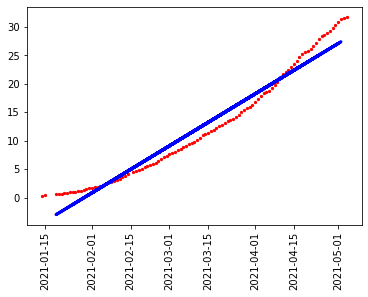

The mean squared error of this model is 3.7973301155024544.

United States will have fully vaccined 69.86% of their population by the date 23/09/2021 based on current tracking.


In [20]:
# determine a country to investigate
country_perc_full = 'United States'
# determine a date
date_perc_full = '23/09/2021'

# call function with the dataset, country and date
# store returned values to be printed
perc_at_date, mse_perc, y_intercept, slope = perc_fully_vaccinated_at_date(vaccination_2, country_perc_full, date_perc_full, True)

if perc_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_perc))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if perc_at_date > 100:
        date_100, mse_date, y_intercept, slope = date_to_be_target_percentage(vaccination_2, country_perc_full, 100, False)
        print("It is predicted the {0} will have fully vaccinate their population by {1}.".format(country_perc_full, ordinal_to_datetime(date_100)))
    else:
        # print data
        print("{0} will have fully vaccined {1}% of their population by the date {2} based on current tracking.".format(country_perc_full, str(round(perc_at_date[0], 2)), date_perc_full))

### For Countries Without people_fully_vaccinated_per_hundred Data
<br>
Calculating total number of vaccinations administered at a given date.
<br><br>
This is for countries that don't have data in the dataset for people_fully_vaccinated_per_hundred, so we will use the total number of vaccines administered to get a guide as to how many people may have been vaccinated (2 doses per each member of population so up to 200%)

In [21]:
# read in cleaned dataset to new data frame
vaccination = pd.read_csv('data/cleaned_vaccination.csv')

In [22]:
# take only the columns of interest
vaccination_3 = vaccination[['country', 'date', 'total_vaccinations_per_hundred']]
# show this shape
print(vaccination_3.shape)

(15344, 3)


In [23]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_3 = vaccination_3[vaccination_3['total_vaccinations_per_hundred'].notna()]
# print the new shape
print(vaccination_3.shape)

(9232, 3)


In [24]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_3['date'] = pd.to_datetime(vaccination_3['date'])
vaccination_3['date'] = vaccination_3['date'].map(dt.datetime.toordinal)

In [25]:
""" 
    Funtion to determine the total vaccinates provided by the given country at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def perc_people_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['total_vaccinations_per_hundred'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the percentage of population fully vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print(country, "has no data for total_vaccinations_per_hundred.")
        return False, False, False, False

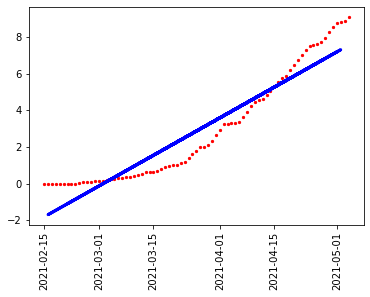

The mean squared error of this model is 0.9690784609297088.

Australia will have administered 35.37% of vaccines required to their population by the date 22/12/2021 based on current tracking (200% required for 2 doses for each person).


In [26]:
# determine a country to investigate
country_perc_ppl = 'Australia'
# determine a date
date_perc_ppl = '22/12/2021'


# call function with the dataset, country and date
# store returned values to be printed
total_at_date, mse_tot_ppl, y_intercept, slope = perc_people_vaccinated_at_date(vaccination_3, country_perc_ppl, date_perc_ppl, True)
    
if total_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    print("The mean squared error of this model is {0}.".format(mse_tot_ppl))
    print()
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if total_at_date > 200:
        print("{0} is predicted to have administered over 200% of vaccinations to their population by {1}".format(country_perc_ppl, date_perc_ppl))
    else:
        # check if country is full vaccinated and tell user that, or print where the country will be at
        print("{0} will have administered {1}% of vaccines required to their population by the date {2} based on current tracking (200% required for 2 doses for each person).".format(country_perc_ppl, str(round(total_at_date[0], 2)), date_perc_ppl))

<br>

## Patrick's Section

### Prediction of How Many People a Country Will Have Vaccinated by a Provided Date

Implementing univariant linear regression on people_vaccinated by date for different countries. Providing a country and a date, this section will determine how many people the country provided will have vaccinated by the given date.
<br>

In [27]:
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')

In [28]:
# take only the columns of interest
vaccination_4 = vaccination[['country', 'date', 'people_vaccinated']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]

# show this shape
print(vaccination_4.shape)
print(country_pop.shape)

(15344, 3)
(235, 2)


In [29]:
# drop all na rows where no data for people fully vaccinated per hundred
vaccination_4 = vaccination_4[vaccination_4['people_vaccinated'].notna()]

# print the new shape
print(vaccination_4.shape)

(8565, 3)


In [30]:
# change date object to date time and then ordinal to be used in linear regression
vaccination_4['date'] = pd.to_datetime(vaccination_4['date'])
vaccination_4['date'] = vaccination_4['date'].map(dt.datetime.toordinal)

In [31]:
""" 
    Funtion to determine the number of the given countries population vaccinated at the provided date
    Requires:
        the pandas dataframe being worked on
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
"""
def numbers_vaccinated_at_date(df, country, date, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date']).reshape((-1, 1))
        Y = np.array(df['people_vaccinated'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the number of people vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return (LR.intercept_ + LR.coef_ * date), mse, LR.intercept_, LR.coef_
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_vaccinated".format(country))
        return False, False, False, False

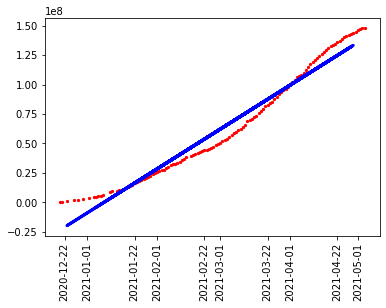

United States will have 310082683.04 people fully vaccined by the date 23/09/2021 based on current tracking.


In [32]:
# determine a country to investigate
country_num = 'United States'
# determine a date
date_num = '23/09/2021'

# call function with the dataset, country and date
# store returned values to be printed
pop_at_date, mse_num, y_intercept, slope = numbers_vaccinated_at_date(vaccination_4, country_num, date_num, True)

if pop_at_date == False:
    pass
else:
    # show the MSE to determine how accurate the model is
    #print("The mean squared error of this model is {0}.".format(mse_num))
    #print()
    
    population = country_pop.loc[country_pop['Country (or dependency)'] == country_num].iat[0,1]
    
    # check if country is full vaccinated and tell user that, or print where the country will be at
    if pop_at_date >= population:
        print("{0} with a population of {1} will be full vaccinated at this date:{2}".format(country_num, population, date_num))
        #date_target, mse_target, y_intercept, slope = date_to_be_target_percentage(vaccination_4, country_num, 100, False)
        #print("It is predicted the {0} will fully vaccinate their population on {1}.".format(country, ordinal_to_datetime(date_target)))
    else:
        # print data
        print("{0} will have {1} people fully vaccined by the date {2} based on current tracking.".format(country_num, str(round(pop_at_date[0], 2)), date_num))

<br>

### Muz's Section

Section for Muz to implement, test and apply machine learning.

In [31]:
vaccination_5 = pd.read_csv('data/cleaned_vaccination.csv')

### Asher's Section

Section for Asher to implement, test and apply machine learning.

In [32]:
vaccination_6 = pd.read_csv('data/cleaned_vaccination.csv')

### Tung's Section

Section for Tung to implement, test and apply machine learning.

In [38]:
vaccination = pd.read_csv('data/cleaned_vaccination.csv')
country_pop = pd.read_csv('data/population_by_country_2020.csv')
country_gdp = pd.read_csv('data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2163564.csv')

In [39]:
# take only the columns of interest
vaccination_5 = vaccination[['country', 'date', 'people_fully_vaccinated_per_hundred']]
country_pop = country_pop[['Country (or dependency)','Population (2020)']]
country_gdp = country_gdp[['Country Name','2019']]
# show this shape
print(vaccination_5.shape)
print(country_pop.shape)
print(country_gdp.shape)

(15344, 3)
(235, 2)
(264, 2)


In [40]:
#merge tables for easier calculation
tung_df = pd.merge(left = vaccination_5, right = country_pop, left_on = 'country', right_on='Country (or dependency)' )
tung_df = pd.merge(left = tung_df, right = country_gdp, left_on = 'country', right_on = 'Country Name')
print(tung_df.shape)
print(tung_df.columns)

(12625, 7)
Index(['country', 'date', 'people_fully_vaccinated_per_hundred',
       'Country (or dependency)', 'Population (2020)', 'Country Name', '2019'],
      dtype='object')


In [41]:
#clear extra columns and na values for people_fully_vaccinated_per_hundred
tung_df = tung_df.drop(['Country (or dependency)', 'Country Name'], axis=1)
tung_df = tung_df[tung_df['people_fully_vaccinated_per_hundred'].notna()]
print(tung_df.shape)
print(tung_df.columns)

(5335, 5)
Index(['country', 'date', 'people_fully_vaccinated_per_hundred',
       'Population (2020)', '2019'],
      dtype='object')


In [ ]:
# change date object to date time and then ordinal to be used in linear regression
tung_df['date'] = pd.to_datetime(tung_df['date'])
tung_df['date'] = tung_df['date'].map(dt.datetime.toordinal)

<br>

In [44]:
""" 
    Function to predict the number of people in a given country being vaccinated for a given time, vaccination percentage, gdp 
        (multivariant regression using date, people fully vaccinated per hundred and gdp vs population)
        a valid country in string format, and
        a date in string format (DD/MM/YYYY)
        a gdp value in decimal format
        a boolean value for plot visualization
"""
def vaccinated_people_by_date_gdp(df, country, date, percentage, gdp, plot):
    # try except to catch countries with no data in people_fully_vaccinated_per_hundred
    try:
        # create a linear regression model
        LR = LinearRegression()
    
        #change date passed to datetime then ordinal data
        date = date_to_ordinal(date)
    
        # take only the portion of the data frame that relates to a specific country
        df = df[df['country'] == country]
    
        # get X and Y variables
        X = np.array(df['date', 'people_vaccinate_per_hundred', '2019']).reshape((-1, 1))
        Y = np.array(df['Population (2020)'])
    
        # Split the training and test data using 30% for testing
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.3, random_state=19)
    
        # train the model
        LR.fit(Xtrain, Ytrain)
    
        # test on test set
        predictions = LR.predict(Xtest)

        # calculate the mean square error
        mse = MSE(predictions, Ytest)
        
        if plot:
            # Plot LR
            plot_LR(ordinal_to_datetime_arr(X), Y, ordinal_to_datetime_arr(Xtest), predictions)
    
        # return the number of people vaccinated at the given date,
        # the mean squared error, the Y intercept and the slope
        return LR.predict(date_to_ordinal(date),percentage,gdp)
    
    except:
        # if country doesnt have this data let the user know
        print("{0} has no data for people_vaccinated".format(country))
        return False

In [45]:
# determine a country to investigate
country_num = 'United States'
# determine a date
date_num = '23/09/2021'
# determine the current percentage of vaccination
percent_num = 0.02
#determine the current gdp
gdp_num = 72436777342

prediction = vaccinated_people_by_date_gdp(tung_df, country_num, date_num, percent_num, gdp_num, True)
print(prediction)

United States has no data for people_vaccinated
False
